In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('files_for_lab/csv_files/marketing_customer_analysis.csv')

In [3]:

# Clean all the columns
def clean_data(data):
    
    d = data.copy()
    
    # Standardize header names: Convert names to lowercase and
    # remove underscores '_'.
    cols = []
    for col in d.columns:
        cols.append(col.lower().replace(' ', '_'))
    d.columns = cols
    
    # Delete duplicate rows
    d = d.drop_duplicates()

    # Drop column "unnamed:_0"
    #df.drop('unnamed:_0', axis=1, inplace=True)

    # Fill all missing values of all columns (with numeric data) with their mean value
    for col in d.select_dtypes(include=np.number).columns:
        d[col] = d[col].fillna(np.mean(d[col]))

    # Fill all missing values of all columns (with categorical data) with their mode value
    for col in d.select_dtypes(include=['object']).columns:
        d[col] = d[col].fillna(d[col].mode())
    
    # Datetime format - Extract the months from the dataset and store in a separate column.
    # Then filter the data to show only the information for the first quarter , ie. January, February and March.
    d['month'] = pd.to_datetime(d['effective_to_date']).dt.month
    d = d[ (d['month']==1) | (d['month']==2) | (d['month']==3) ]

    # Reset row labels
    d = d.reset_index(drop=True)
    
    return d


In [4]:

import matplotlib.pyplot as plt
import seaborn as sns

def explore_data(data):

    # Show info and description of dataframe
    display(data.info())
    display(data.describe())

    # Show a plot of the total number of responses. (Piechart)
    number_of_response    = len(data[data['response']=='Yes'])
    number_of_no_response = len(data) - number_of_response

    x = [number_of_response, number_of_no_response]
    labels = ['responded', 'not responded']
    colors = ['green', 'red']

    fig, ax = plt.subplots()
    ax.pie(x, colors=colors, labels=labels, autopct='%.1f%%')
    ax.set_title('reponses')

    plt.show()
    
   
    # Show a plot of the response rate by the sales channel.
    hist_data = {}
    for x in list(data['sales_channel'].unique()):
        hist_data[x] = len(data[(data['response']=='Yes') & (data['sales_channel']==x) ])

    ind = np.arange(len(hist_data))
    palette = sns.color_palette("husl", len(hist_data))

    plt.bar(ind, list(hist_data.values()), color=palette)
    plt.xticks(ind, list(hist_data.keys()))
    plt.title("Response rate by sales channel")
    plt.ylabel("responses")
    plt.xlabel("sales_channel")
    plt.show()
    
    
    # Show a plot of the response rate by the total claim amount.
    palette = {"No": "red", "Yes": "green"}
    sns.boxplot(data, y="total_claim_amount", x="response", palette=palette)

   
    # Show a plot of the response rate by income.
    palette = {"No": "red", "Yes": "green"}
    sns.boxplot(data, y="income", x="response", palette=palette)
    
    
    # Get the numeric data into dataframe called `numerical` and categorical
    # columns in a dataframe called `categoricals`.
    numerical   = data.select_dtypes(np.number)
    categorical = data.select_dtypes(object)
                 
    display(numerical.head())
    display(categorical.head())

    
    # Now we will try to check the normality of the numerical variables visually
    # Use seaborn library to construct distribution plots for the numerical variables
    #lt.style.use('classic')
    for column_name in numerical.columns:
        sns.displot(numerical[column_name], kde=True)

    # Use Matplotlib to construct histograms
    plt.style.context('ggplot')    
    for column_name in numerical.columns:
        fig,ax = plt.subplots()
        ax.set_title(column_name)
        plt.hist(numerical[column_name], bins=20)
        plt.show()

    # Do the distributions for different numerical variables look like a normal distribution
    for column_name in numerical.columns:
        iqr = np.percentile(df[column_name],75) - np.percentile(df[column_name],25)
        upper_limit = np.percentile(df[column_name],75) + 1.5*iqr
        lower_limit = np.percentile(df[column_name],25) - 1.5*iqr

        df_tmp = data[(data[column_name]>lower_limit) & (data[column_name]<upper_limit)]
        if len(df_tmp) > 0:
            sns.displot(df_tmp[column_name])
        plt.show()
    
    
    # Check the correlation between the features and plot a heatmap
    numerical.corr()
    sns.heatmap(numerical.corr())
    
    return data


In [5]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


def process_data(data):
    '''
        Processes the data.
        
        Input  -> data  Dataframe to process
        Output -> X     Standardized columns used for prediction
        Output -> y     Column to predict
    '''
    d = data.copy()
    
    # Do the X-y split
    y = d['total_claim_amount']
    X = d.drop(['total_claim_amount'], axis=1)
    print(f'X-shape = {X.shape}')
    print(f'y-shape = {y.shape}')
    
    
    # Split X into numerical and categorial columns
    X_num = X.select_dtypes(np.number)
    X_cat = X.select_dtypes(object)

    
    # Normalize all numerical columns of X using the MinMaxScaler
    # This will scale all within a range from 0.0 to 1.0.
    minMaxScaler = MinMaxScaler()
    minMaxScaler.fit(X_num)
    X_normalized = minMaxScaler.transform(X_num)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X_num.columns)
    print(f'X-normalized Shape = {X_normalized.shape}')
    display(X_normalized_df)
    
    pd.DataFrame(X_normalized, columns=X_num.columns)

    # We delete column 'customer' and 'effective_to_date' since it doesn't make sense to
    # convert them to numerical.
    X_cat_to_encode = X_cat.drop(['customer','effective_to_date'], axis=1)
    X_cat_to_encode.columns.tolist()


    # OneHot Encoding
    # Convert categorial columns into multiple numerical columns.
    encoder = OneHotEncoder()
    encoder.fit(X_cat_to_encode)
    print(encoder.categories_)
    encoded = encoder.transform(X_cat_to_encode).toarray()
    #onehot_encoded = pd.DataFrame(encoded,columns=encoder.categories_)
    onehot_encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
    onehot_encoded_df.head()
    

    # Concatenate normalized numerical columns with one-hot-encoded columns
    X = pd.concat([X_normalized_df, onehot_encoded_df], axis=1)
    print(f'Old number of columns = {len(d.columns.tolist())}')
    print(f'New number of columns = {len(X.columns.tolist())}')

    return X,y


In [6]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
def train_and_validate_model(X, y, test_size=0.2, random_state=42):
    
    # Split X,y into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state)
    print(f'X_train: {X_train.shape}')
    print(f'X_test:  {X_test.shape}')
    print(f'y_train: {y_train.shape}')
    print(f'y_test:  {y_test.shape}')

    
    # Apply linear regression, train/fit the model
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    
    # Predict training set
    y_pred_train = lm.predict(X_train)
    print(f"y_pred_train = {y_pred_train}")

    # R2 score for training set
    r2_train = r2_score(y_train, y_pred_train)
    print(f"r2_train     = {r2_train}")

    # Predict test set
    y_pred_test  = lm.predict(X_test)
    print(f"y_pred_test = {y_pred_test}")

    # R2 score for test set
    r2_test = r2_score(y_test, y_pred_test)
    print(f"r2_test     = {r2_test}")


    # MSE - Mean Squared Error
    mse = mean_squared_error(y_test,y_pred_test)
    print(f'MSE = {mse}')

    # RMSE - Root Mean Squared Error
    rmse = np.sqrt(mse)
    print(f'RMSE = {rmse}')

    # MAE - Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred_test)
    print(f'MAE = {mae}')


In [7]:
# Clean data
df  = clean_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer                       9134 non-null   object 
 1   state                          9134 non-null   object 
 2   customer_lifetime_value        9134 non-null   float64
 3   response                       9134 non-null   object 
 4   coverage                       9134 non-null   object 
 5   education                      9134 non-null   object 
 6   effective_to_date              9134 non-null   object 
 7   employmentstatus               9134 non-null   object 
 8   gender                         9134 non-null   object 
 9   income                         9134 non-null   int64  
 10  location_code                  9134 non-null   object 
 11  marital_status                 9134 non-null   object 
 12  monthly_premium_auto           9134 non-null   i

None

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,1.463762
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,0.498712
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,1.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,1.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,1.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,2.000000
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,2.000000


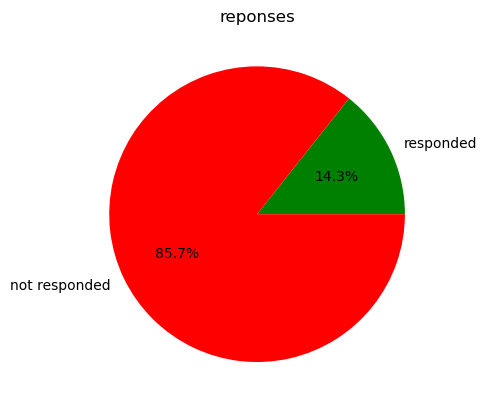

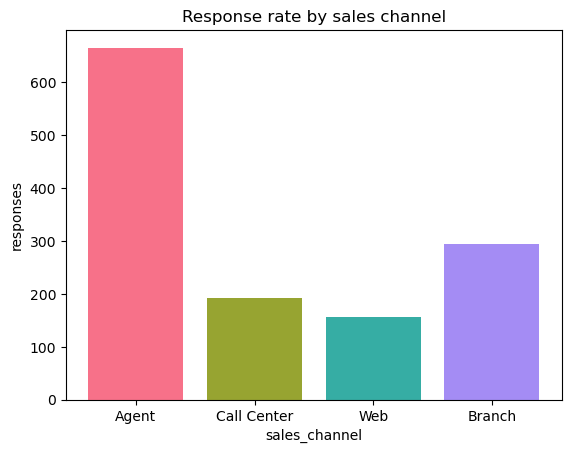

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
0,2763.519279,56274,69,32,5,0,1,384.811147,2
1,6979.535903,0,94,13,42,0,8,1131.464935,1
2,12887.431650,48767,108,18,38,0,2,566.472247,2
3,7645.861827,0,106,18,65,0,7,529.881344,1
4,2813.692575,43836,73,12,44,0,1,138.130879,2


,customer,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,BU79786,Washington,No,Basic,Bachelor,2/24/11,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,QZ44356,Arizona,No,Extended,Bachelor,1/31/11,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,AI49188,Nevada,No,Premium,Bachelor,2/19/11,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,WW63253,California,No,Basic,Bachelor,1/20/11,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,HB64268,Washington,No,Basic,Bachelor,2/3/11,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


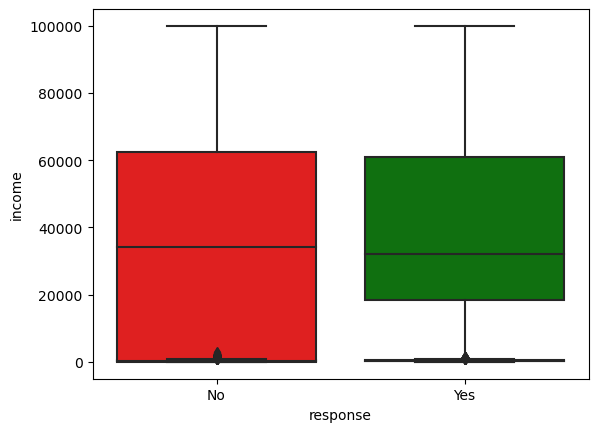

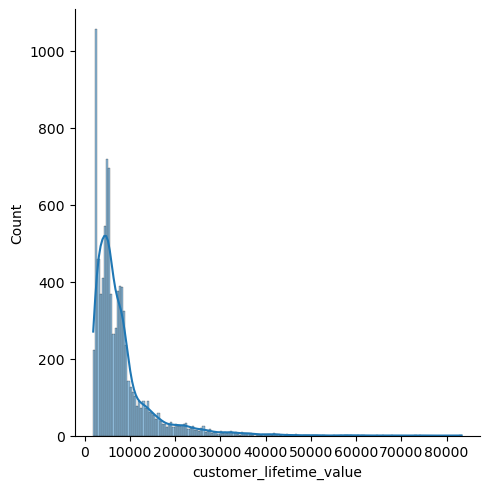

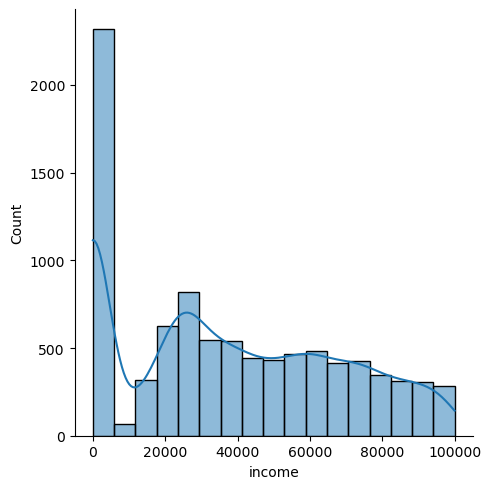

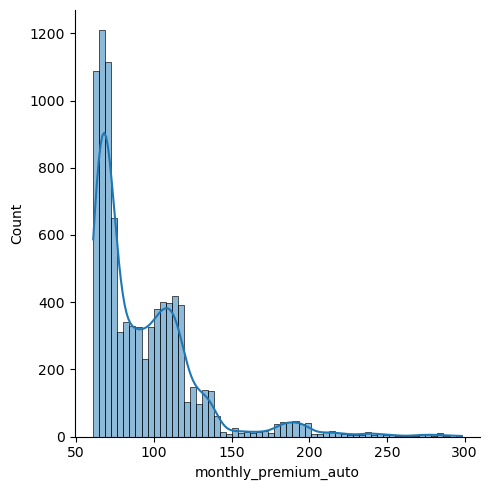

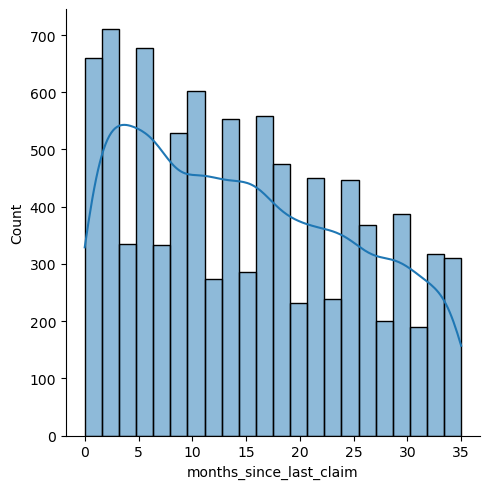

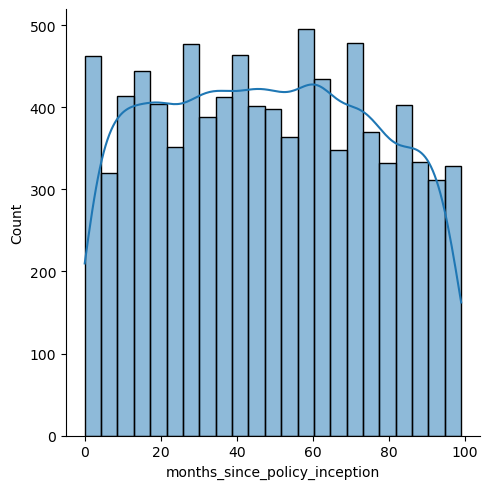

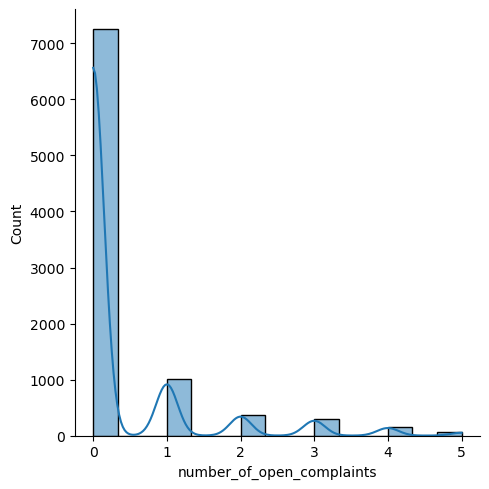

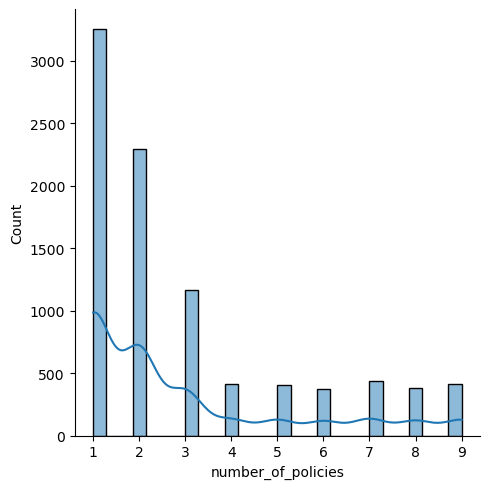

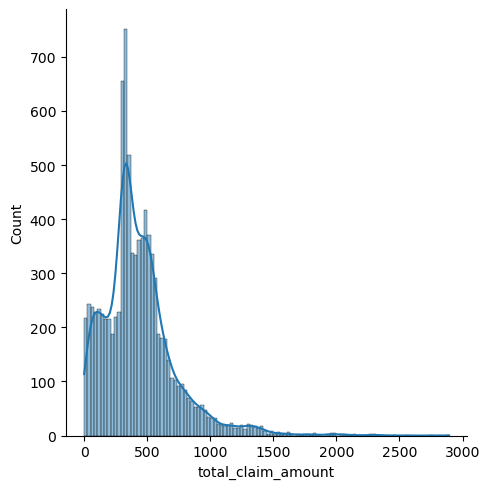

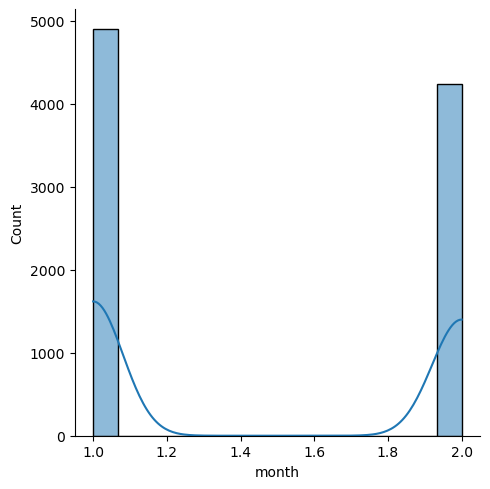

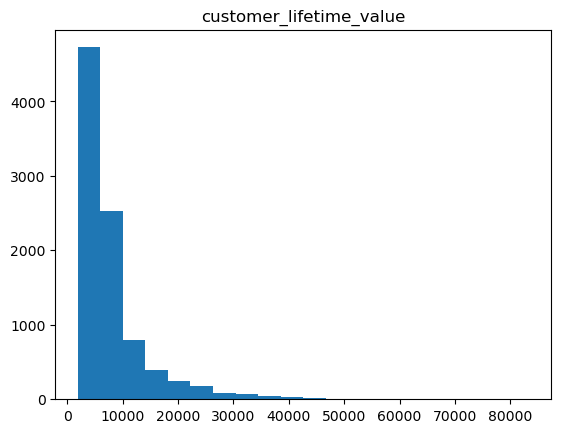

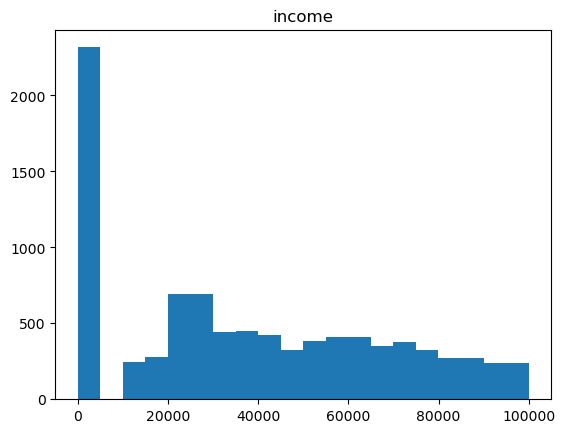

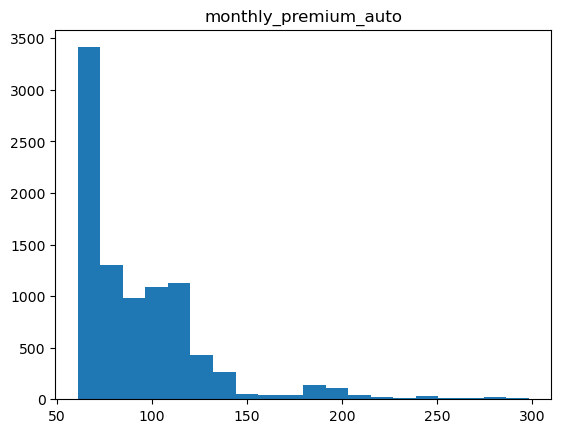

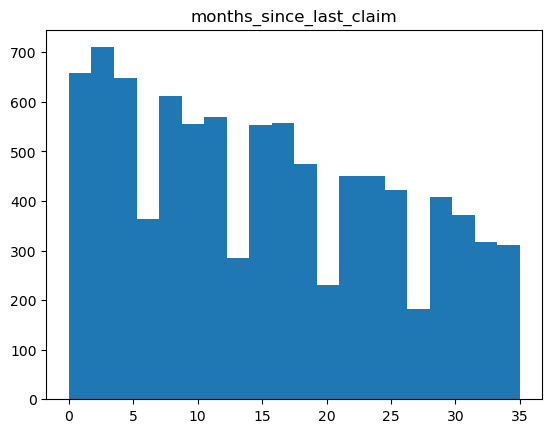

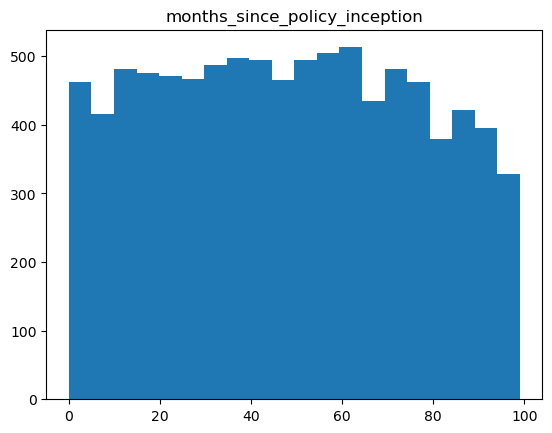

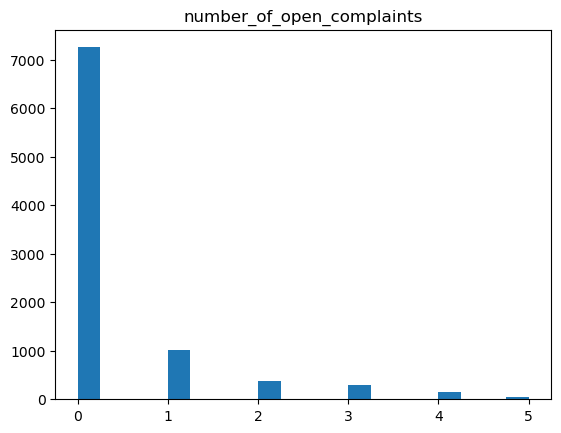

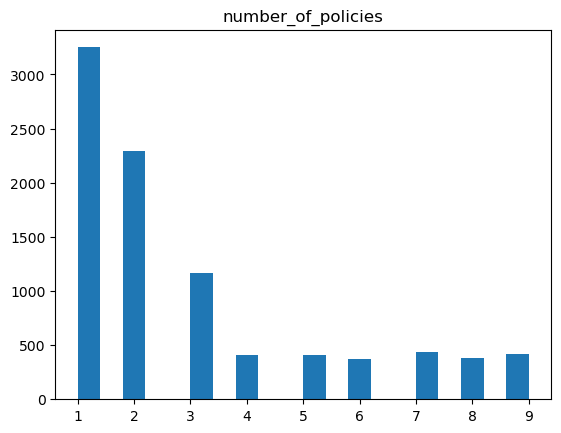

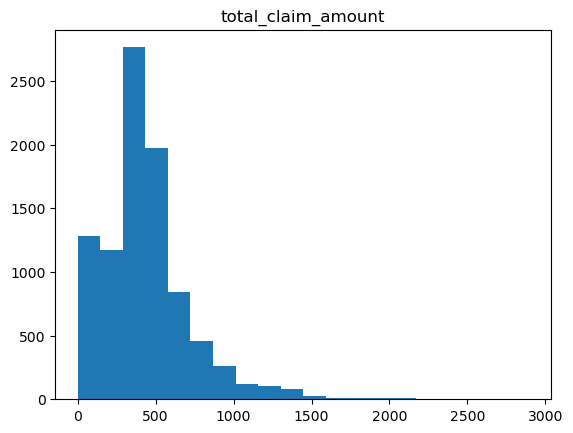

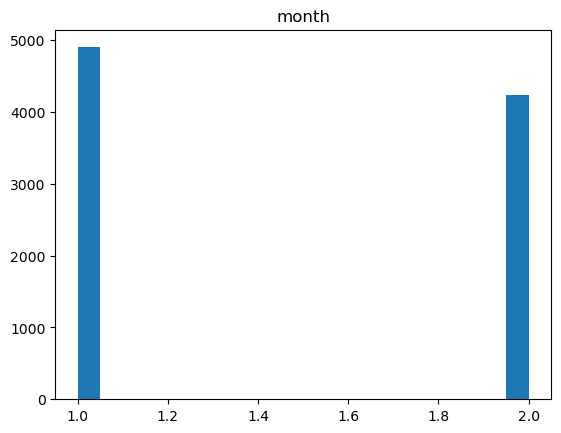

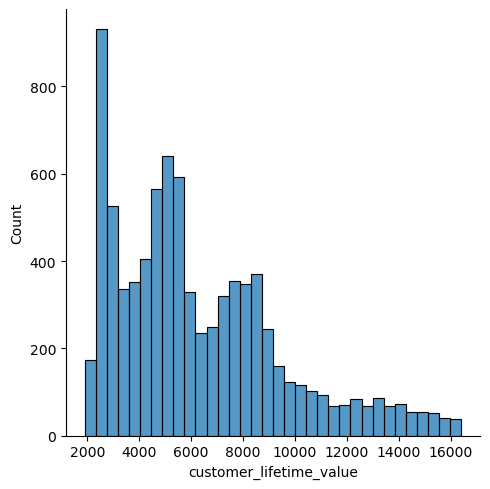

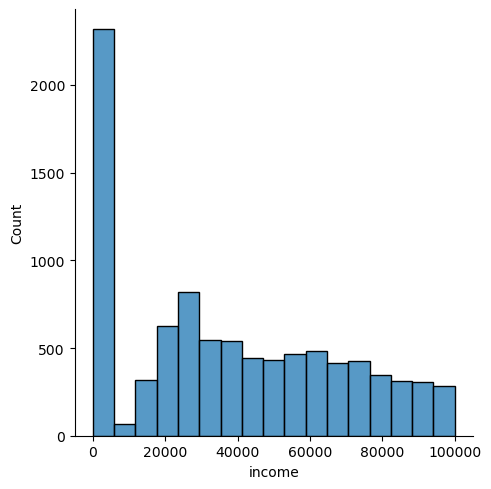

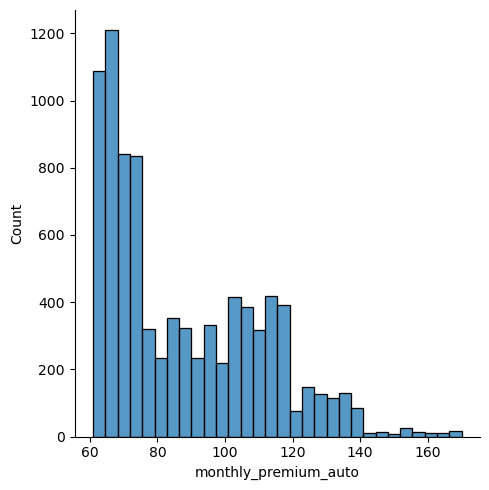

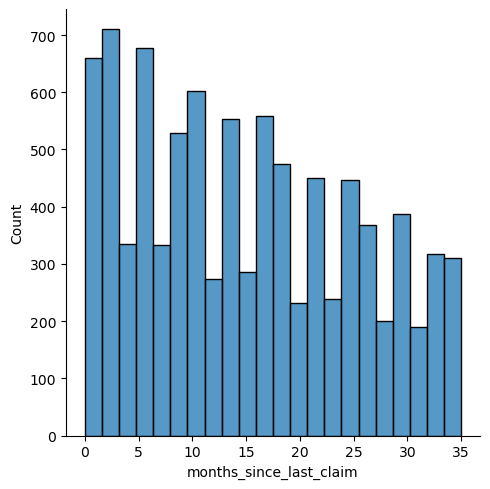

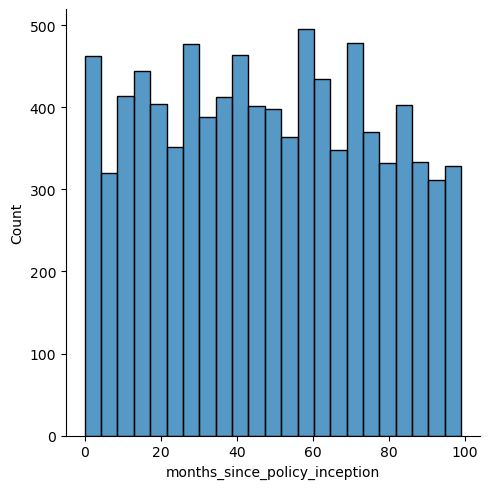

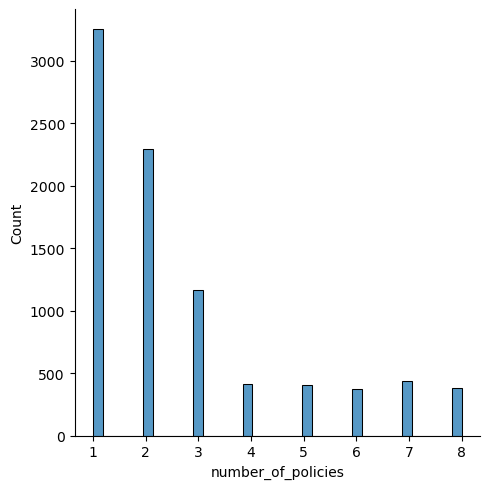

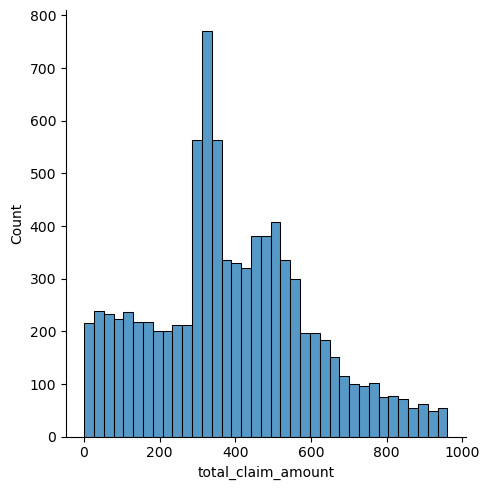

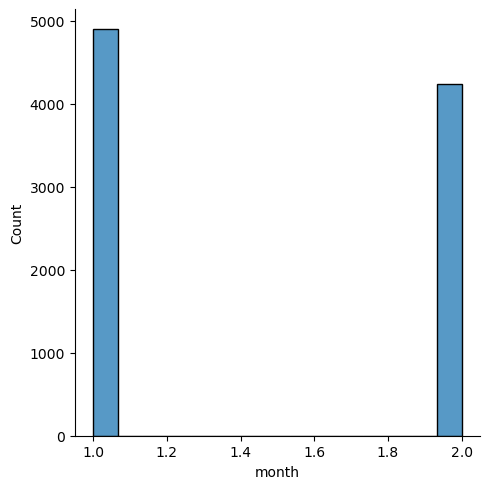

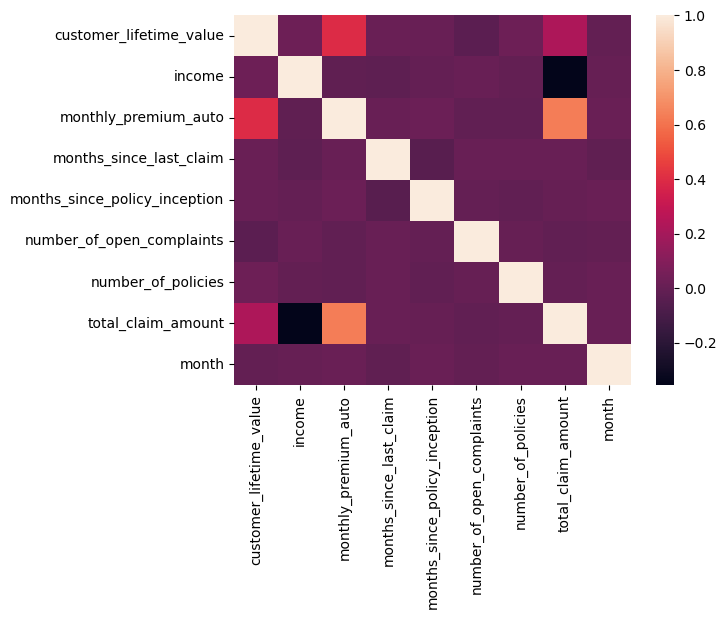

In [8]:
# Explore data
df  = explore_data(df)

In [9]:
# Process data
X,y = process_data(df)

X-shape = (9134, 24)
y-shape = (9134,)
X-normalized Shape = (9134, 8)


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,month
0,0.010629,0.562847,0.033755,0.914286,0.050505,0.0,0.000,1.0
1,0.062406,0.000000,0.139241,0.371429,0.424242,0.0,0.875,0.0
2,0.134960,0.487763,0.198312,0.514286,0.383838,0.0,0.125,1.0
3,0.070589,0.000000,0.189873,0.514286,0.656566,0.0,0.750,0.0
4,0.011245,0.438443,0.050633,0.342857,0.444444,0.0,0.000,1.0
...,...,...,...,...,...,...,...,...
9129,0.264137,0.719547,0.050633,0.514286,0.898990,0.0,0.125,1.0
9130,0.014719,0.216081,0.075949,0.400000,0.282828,0.0,0.000,1.0
9131,0.076951,0.000000,0.101266,0.257143,0.373737,0.6,0.125,1.0
9132,0.069098,0.219452,0.147679,0.971429,0.030303,0.0,0.250,1.0


[array(['Arizona', 'California', 'Nevada', 'Oregon', 'Washington'],
      dtype=object), array(['No', 'Yes'], dtype=object), array(['Basic', 'Extended', 'Premium'], dtype=object), array(['Bachelor', 'College', 'Doctor', 'High School or Below', 'Master'],
      dtype=object), array(['Disabled', 'Employed', 'Medical Leave', 'Retired', 'Unemployed'],
      dtype=object), array(['F', 'M'], dtype=object), array(['Rural', 'Suburban', 'Urban'], dtype=object), array(['Divorced', 'Married', 'Single'], dtype=object), array(['Corporate Auto', 'Personal Auto', 'Special Auto'], dtype=object), array(['Corporate L1', 'Corporate L2', 'Corporate L3', 'Personal L1',
       'Personal L2', 'Personal L3', 'Special L1', 'Special L2',
       'Special L3'], dtype=object), array(['Offer1', 'Offer2', 'Offer3', 'Offer4'], dtype=object), array(['Agent', 'Branch', 'Call Center', 'Web'], dtype=object), array(['Four-Door Car', 'Luxury Car', 'Luxury SUV', 'SUV', 'Sports Car',
       'Two-Door Car'], dtype=object), ar

In [10]:
# Train and validate model
train_and_validate_model(X,y)

X_train: (7307, 65)
X_test:  (1827, 65)
y_train: (7307,)
y_test:  (1827,)
y_pred_train = [168. 585. 397. ... 818. 770. 279.]
r2_train     = 0.7738940036945714
y_pred_test = [182. 467. 460. ... 196. 516. 648.]
r2_test     = 0.7622165285975593
MSE = 18906.41128876555
RMSE = 137.50058650335114
MAE = 95.3081219228243


In [16]:
from sklearn.preprocessing import PowerTransformer

def process_data_v2(data):
    '''
        Processes the data (Version 2).
        
        Input  -> data  Dataframe to process
        Output -> X     Standardized columns used for prediction
        Output -> y     Column to predict
    '''
    d = data.copy()
    
    # Do the X-y split
    y = d['total_claim_amount']
    X = d.drop(['total_claim_amount'], axis=1)
    
    # Split X into numerical and categorial columns
    X_num = X.select_dtypes(np.number)
    X_cat = X.select_dtypes(object)

    # Normalize X using the PowerTransformer
    powerTransformer = PowerTransformer()
    powerTransformer.fit(X_num)
    X_normalized = powerTransformer.transform(X_num)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X_num.columns)

    # We delete column 'customer' and 'effective_to_date' since it doesn't make sense to
    # convert them to numerical.
    X_cat_to_encode = X_cat.drop(['customer','effective_to_date'], axis=1)
    X_cat_to_encode.columns.tolist()

    # OneHot Encoding
    # Convert categorial columns into multiple numerical columns.
    encoder = OneHotEncoder()
    encoder.fit(X_cat_to_encode)
    encoded = encoder.transform(X_cat_to_encode).toarray()
    onehot_encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
    
    # Concatenate normalized numerical columns with one-hot-encoded columns
    X = pd.concat([X_standardized_df, onehot_encoded_df], axis=1)

    return X,y

In [17]:
# Process data, train and validate it again
# to see if we get better predictions...

X,y = process_data_v2(df)
train_and_validate_model(X,y, 0.3)

X_train: (6393, 65)
X_test:  (2741, 65)
y_train: (6393,)
y_test:  (2741,)
y_pred_train = [718.    654.375 619.875 ... 801.75  716.5   310.625]
r2_train     = 0.7644877614440027
y_pred_test = [210.    448.25  440.875 ... 643.5   104.375 589.25 ]
r2_test     = 0.744323414883777
MSE = 20871.981210814345
RMSE = 144.47138543952
MAE = 97.45949375994162
